## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import facts
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report
from facts.utils import load_rules_by_if,save_rules_by_if

import matplotlib.pyplot as plt

In [2]:
DATAFILE = '../../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['religion','politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['religion','politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_alias = {"M": "Male", "F": "Female", "Unknown": "Unknown"}

## Load Dataset

In [3]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


In [4]:
ad_conversion_dataset.gender = ad_conversion_dataset.gender.map(sensitive_alias)
ad_conversion_dataset.rename(columns = {'age':'ages'}, inplace = True)


# Preprocessing

In [5]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,religion,politics,gender,parents,ages,income,area,college_educated,homeowner,true_conversion
0,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Other,Unknown,Unknown,1,55-64,Unknown,Urban,1,1,0
2,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
3,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
4,Unknown,Unknown,Female,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1443135,Other,Unknown,Female,1,25-34,Unknown,Unknown,1,1,0
1443136,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0


In [6]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [7]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

Wall time: 39.6 s


c:\Users\Nikolas Theol\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [8]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    432231
           1       0.00      0.10      0.00       712

    accuracy                           0.91    432943
   macro avg       0.50      0.51      0.48    432943
weighted avg       1.00      0.91      0.95    432943



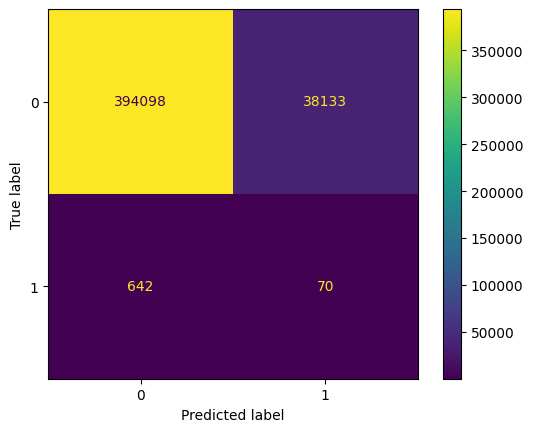

In [9]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [10]:
#Uncomment if you want to find new rules with different support

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='gender',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 1741/1741 [00:00<00:00, 144111.69it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 1734/1734 [00:00<00:00, 4135.43it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 6148/6148 [41:42<00:00,  2.46it/s]  


Number of if-thens: 6148


Uncomment the following block if you wish to load rules object from disk.

In [13]:
# import dill

# with open("rulesAdCampaing_atomic.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [17]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If ages = 55-64, area = Urban, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 15.09% covered
		Make religion = Christianity with correctness 100.00%.
		Make religion = Other with correctness 100.00%.
		Make area = Rural, religion = Other with correctness 100.00%.
		Make area = Rural, religion = Christianity with correctness 100.00%.
	Protected Subgroup 'Female', 13.68% covered
		Make religion = Christianity with correctness 0.00%.
		Make religion = Other with correctness 0.00%.
		Make area = Rural, religion = Other with correctness 0.00%.
		Make area = Rural, religion = Christianity with correctness 0.00%.
If ages = 55-64, area = Urban, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 15.09% covered
		Make religion = Christianity with correctness 100.00%.
		Make religion = Other with correctness 100.00%.
		Make area = Rural, re

In [18]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdCampaing_atomic.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [21]:
num_features = []
cate_features = ['religion','politics', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
ord_features = []

feature_weights = {'religion':5,'politics':2, 'parents':3, 'ages':10, 'income':3, 'area':2, 'college_educated':3, 'homeowner':1}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
)
params = ParameterProxy(featureChanges=comparators)

In [23]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="gender", params=params)

100%|██████████| 1432/1432 [14:28<00:00,  1.65it/s] 


In [24]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdCampaing_cumulative.data", "wb") as outf:
    dill.dump(rules_with_cumulative, outf)

## Minimum cost above threshold

In [32]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If homeowner = 1, parents = 0:
	Protected Subgroup 'Male', 5.74% covered out of 76769
		Make homeowner = 0 with effectiveness 51.94%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 5.25% covered out of 160992
		Make homeowner = 0, parents = 1 with effectiveness 96.52%.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 3.
If college_educated = 1, homeowner = 1, parents = 0:
	Protected Subgroup 'Male', 5.41% covered out of 76769
		Make homeowner = 0 with effectiveness 52.13%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 4.97% covered out of 160992
		Make homeowner = 0, parents = 1 with effectiveness 96.60%.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 3.


## Number above threshold

In [34]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If area = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 53.09% covered out of 76769
		Make area = Urban, religion = Christianity with effectiveness 85.47%.
		Make area = Urban, religion = Other with effectiveness 85.47%.
		Make area = Rural, religion = Christianity with effectiveness 90.52%.
		Make area = Rural, religion = Other with effectiveness 90.52%.
		Aggregate cost of the above recourses = -4.00
	Protected Subgroup 'Female', 48.86% covered out of 160992
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 4.
If area = Unknown, homeowner = 1, religion = Unknown:
	Protected Subgroup 'Male', 51.81% covered out of 76769
		Make homeowner = 0 with effectiveness 90.59%.
		Make homeowner = 0, religion = Christianity with effectiveness 99.24%.
		Make homeowner = 0, religion = Other with effectiveness 99.27%.
		Make area = Urban, religion = Christianity with effectiveness 85.15%.
		M